In [200]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [19]:
data = pd.read_excel("summary_per_color_group.xlsx")
data

,Unnamed: 0,T258_dH+_red_mean,T258_dH+_red_std,T258_dH+_red_min,T258_dH+_red_25%,T258_dH+_red_50%,T258_dH+_red_75%,T258_dH+_red_max,T258_dH-_red_mean,T258_dH-_red_std,...,T278_SMR_diff_25%,T278_SMR_diff_50%,T278_SMR_diff_75%,T278_SMR_diff_max,T278_SMR_corr,T278_SMR_tau,id_test_attempt,id_sample,age,sex
0,61005,2.75,1.500000,1,1.75,3.0,4.00,4,1.00,0.816497,...,-0.111650,-0.003722,0.110599,0.298893,-0.348606,-0.231483,0,0,20.010959,1
1,47000,2.25,0.957427,1,1.75,2.5,3.00,3,0.75,0.500000,...,-0.051903,0.048618,0.063985,0.219723,0.102884,0.066421,0,1,20.013699,0
2,47466,1.75,0.957427,1,1.00,1.5,2.25,3,0.50,0.577350,...,-0.064603,-0.051664,0.073810,0.274372,-0.202019,-0.016667,0,2,20.112329,0
3,59980,2.00,0.816497,1,1.75,2.0,2.25,3,0.75,0.500000,...,-0.055315,-0.027076,0.070588,0.181467,0.019172,-0.049460,0,3,20.158904,0
4,47927,2.00,0.816497,1,1.75,2.0,2.25,3,0.25,0.500000,...,-0.129545,0.003198,0.072435,0.324830,-0.149060,-0.191063,1,4,20.158904,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998,54377,6.75,2.629956,3,6.00,7.5,8.25,9,10.00,0.000000,...,-0.168182,-0.004284,0.123874,0.438725,0.357924,0.218462,0,2811,82.610959,1
2999,54127,7.25,3.304038,3,6.00,7.5,8.75,11,5.50,2.380476,...,-0.075099,-0.000922,0.052347,0.393750,-0.397136,-0.306667,0,2812,83.375342,0
3000,54142,10.25,6.184658,3,7.50,10.0,12.75,18,7.25,1.892969,...,-0.103839,0.003205,0.131783,0.408466,-0.188465,-0.295840,0,2813,83.471233,0
3001,51135,13.00,4.966555,7,10.75,13.0,15.25,19,3.25,2.753785,...,-0.103728,-0.051200,0.083958,0.212740,-0.194597,-0.159420,0,2814,83.567123,1


In [20]:
x = data.drop(columns="age")
y = data["age"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)


# Построение моделей регресии

## KNN
Подход, основанный на предположении, что похожие объекты имеют схожие значения целевой переменной. В отличие от сложных моделей, KNN не строит явную математическую зависимость, а просто запоминает обучающие данные и для каждого нового объекта ищет k наиболее близких примеров, чтобы предсказать их среднее значение

In [214]:
def built_real_pred_age_scatter(real_train, real_test, pred_test, pred_train, mae_test, mae_train):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax1, ax2 = axes
    
    sns.scatterplot(x=real_test, y=pred_test, alpha=0.5, ax=ax1, color='green')
    ax1.plot([10,85], [10,85], color="grey", linestyle='--')
    ax1.set_title('Тестовые данные', loc='left', fontsize=15)
    corr_test, _ = pearsonr(real_test, pred_test)
    ax1.text(0.05, 0.86, f'corr: {corr_test:.2f}', transform=ax1.transAxes, fontsize=12)
    ax1.text(0.05, 0.95, f'MAE: {mae_test:.2f}', transform=ax1.transAxes, fontsize=12)
    lowess_res = sm.nonparametric.lowess(exog=real_test, endog=pred_test, frac=0.3)     
    ax1.plot(lowess_res[:, 0], lowess_res[:, 1], linewidth=2, color='black', label='Линия тренда (LOWESS)')
    sns.regplot(x=real_test, y=pred_test, ax=ax1, scatter=False, color='red', label='Линия регрессии')
    ax1.set_xlabel('Реальный возраст', fontsize=15, fontweight='light')
    ax1.set_ylabel('Предсказанный возраст', fontsize=15, fontweight='light')
    ax1.legend()

    
    sns.scatterplot(x=real_train, y=pred_train, alpha=0.5, ax=ax2)
    ax2.plot([10,85], [10,85], color="grey", linestyle='--')
    ax2.set_title('Обучающие данные', loc='left', fontsize=15)
    corr_train, _ = pearsonr(real_train, pred_train)
    ax2.text(0.05, 0.86, f'corr: {corr_train:.2f}', transform=ax2.transAxes, fontsize=12)
    ax2.text(0.05, 0.95, f'MAE: {mae_train:.2f}', transform=ax2.transAxes, fontsize=12) #4 параметр это система координат относительно осей
    lowess_res = sm.nonparametric.lowess(exog=real_train, endog=pred_train, frac=0.3)     
    ax2.plot(lowess_res[:, 0], lowess_res[:, 1], linewidth=2, color='black', label='Линия тренда (LOWESS)')
    sns.regplot(x=real_train, y=pred_train, ax=ax2, scatter=False, color='red', label='Линия регрессии')
    ax2.set_xlabel('Реальный возраст', fontsize=15, fontweight='light')
    ax2.set_ylabel('Предсказанный возраст', fontsize=15, fontweight='light')
    ax2.legend()

In [47]:
knn = KNeighborsRegressor()  
knn.fit(x_train, y_train)
y_pred_knn_test = knn.predict(x_test)
y_pred_knn_train = knn.predict(x_train)
mae_knn_train = mean_absolute_error(y_train, y_pred_knn_train)
mae_knn_test = mean_absolute_error(y_test, y_pred_knn_test)
print(f"MAE на тренировочной выборке {mae_knn_train}\nMAE на тестовой выборке {mae_knn_test}\n")

MAE на тренировочной выборке 7.4238710207247385
MAE на тестовой выборке 9.37490702710095



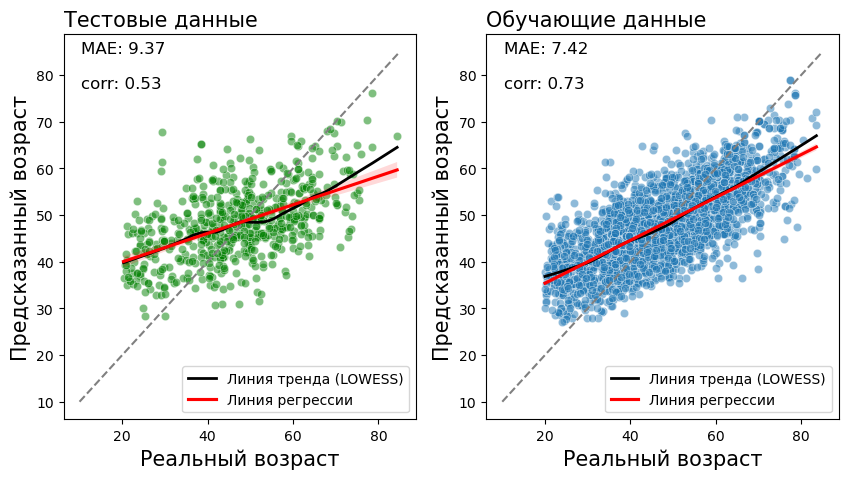

In [216]:
built_real_pred_age_scatter(y_train, y_test, y_pred_knn_test, y_pred_knn_train, mae_knn_test, mae_knn_train) 

## SVR
SVR строит математическую модель, пытаясь найти гиперплоскость, которая минимизирует ошибку, но при этом учитывает только те точки, которые выходят за пределы заданной границы (эпсилон-трубки). Это делает SVR устойчивым к выбросам и хорошо работающим в высокоразмерных пространствах

In [43]:
svr = SVR()
svr.fit(x_train, y_train)
y_pred_svr_test = svr.predict(x_test)
y_pred_svr_train = svr.predict(x_train)
mae_svr_test = mean_absolute_error(y_test, y_pred_svr_test)
mae_svr_train = mean_absolute_error(y_train, y_pred_svr_train)
print(f"MAE на тренировочной выборке {mae_svr_train}\nMAE на тестовой выборке {mae_svr_test}\n")

MAE на тренировочной выборке 11.067380756030694
MAE на тестовой выборке 11.00144280066573



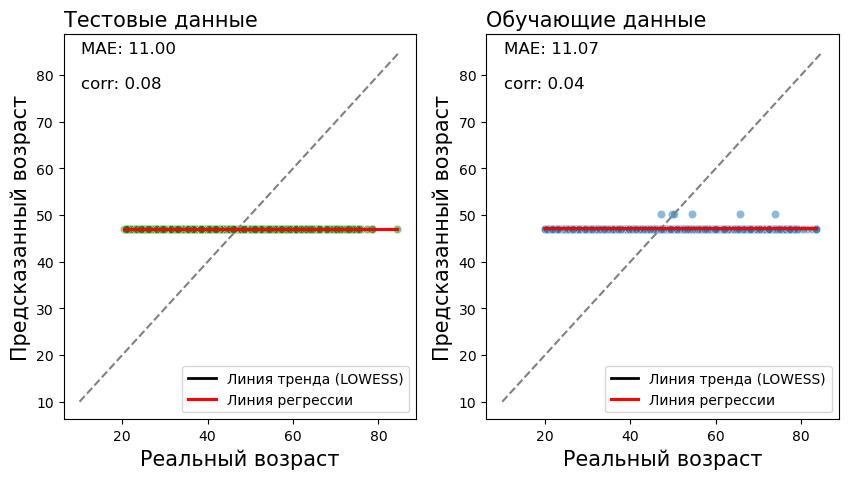

In [218]:
built_real_pred_age_scatter(y_train, y_test, y_pred_svr_test, y_pred_svr_train, mae_svr_test, mae_svr_train) 

## Дерево решений
Работают по принципу последовательного разбиения данных на подгруппы, чтобы минимизировать дисперсию целевой переменной в каждом листе. Они интуитивно понятны, так как их можно визуализировать, и они автоматически учитывают нелинейные зависимости и взаимодействия признаков.

In [41]:
tree = DecisionTreeRegressor(random_state=10)
tree.fit(x_train, y_train)
y_pred_tree_train = tree.predict(x_train)
y_pred_tree_test = tree.predict(x_test)
mae_tree_test = mean_absolute_error(y_test, y_pred_tree_test)
mae_tree_train = mean_absolute_error(y_train, y_pred_tree_train)
print(f"MAE на тренировочной выборке {mae_tree_train}\nMAE на тестовой выборке {mae_tree_test}\n")

MAE на тренировочной выборке 4.437194436470234e-17
MAE на тестовой выборке 0.061812960134934966



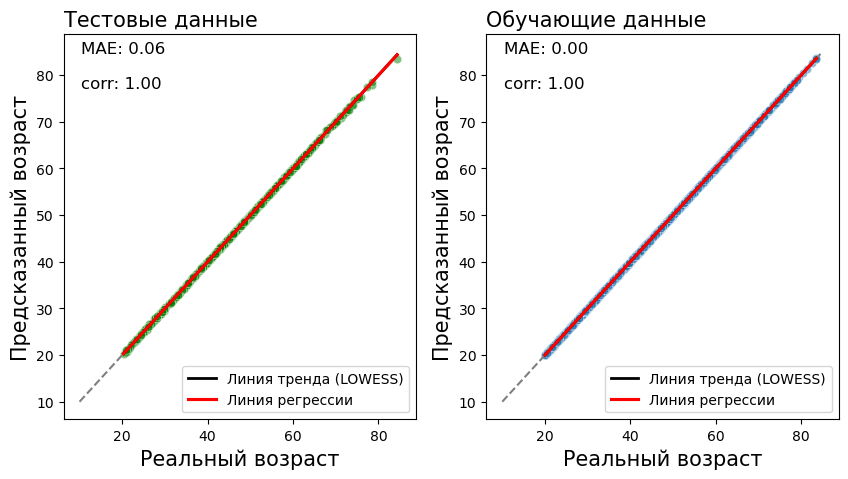

In [220]:
built_real_pred_age_scatter(y_train, y_test, y_pred_tree_test, y_pred_tree_train, mae_tree_test, mae_tree_train) 

## Градиентный бустиннг
Это более продвинутый подход, который строит ансамбль из множества слабых моделей (обычно деревьев), последовательно улучшая предсказания за счёт минимизации ошибки через градиентный спуск. Он сочетает в себе преимущества деревьев — работу с нелинейными зависимостями и категориальными признаками — с высокой точностью и устойчивостью к переобучению благодаря регуляризации.

In [35]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
y_pred_xgb_test = xgb.predict(x_test)
y_pred_xgb_train = xgb.predict(x_train)
mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb_test)
mae_xgb_train = mean_absolute_error(y_train, y_pred_xgb_train)
print(f"MAE на тренировочной выборке {mae_xgb_train}\nMAE на тестовой выборке {mae_xgb_test}\n")

MAE на тренировочной выборке 0.004160646248000624
MAE на тестовой выборке 0.11625800459873951



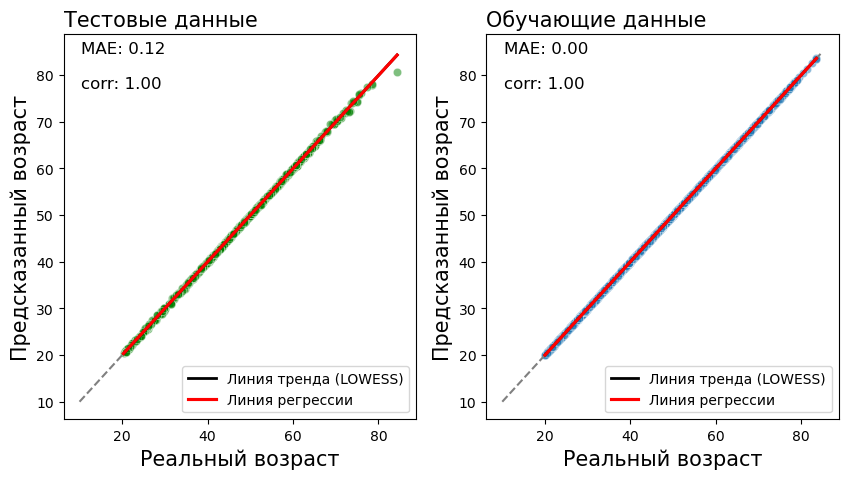

In [222]:
built_real_pred_age_scatter(y_train, y_test, y_pred_xgb_test, y_pred_xgb_train, mae_xgb_test, mae_xgb_train) 